# Investigating Feature Usage Constraints in Decision Tree Splits Using Synthetic Data


## Objective

- In this notebook, I aim to explore the impact of limiting feature reuse in decision tree construction. I have implemented a custom decision tree algorithm that allows me to control how many times each feature can be used for splitting. 

- To evaluate whether such a restriction is appropriate, I generate a synthetic 2D dataset with clearly separable class regions that require multiple splits along the same feature for accurate classification. 

- **The main goal is to demonstrate that enforcing a hard limit on the number of times a feature can be used may prevent the model from learning the optimal decision boundaries** — especially when the same feature continues to provide the best splits.

- Through visualizations of the decision boundaries and the resulting accuracy metrics, I compare the performance of the tree with and without the feature usage constraint.


### Libries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import plotly.express as px
import plotly.graph_objects as go

In [4]:
import plotly.io as pio
pio.renderers.default = 'png'


## Creating a Practice Dataset to Test the Algorithm

To test the behavior and performance of my custom decision tree algorithm, I begin by generating a small synthetic dataset. This dataset contains two numerical features and a binary target variable. It is designed purely for experimentation, allowing me to validate that the algorithm handles basic classification tasks correctly and that the core splitting logic functions as expected.

The generated data is visualized on a 2D plot to provide an intuitive understanding of the distribution and separability of the classes.


         x1        x2  target
0  0.931059  2.245238       0
1 -1.107099  1.095919       0
2  0.014190  0.973612       1
3  1.031872  2.045483       0
4 -2.000897  0.187708       0


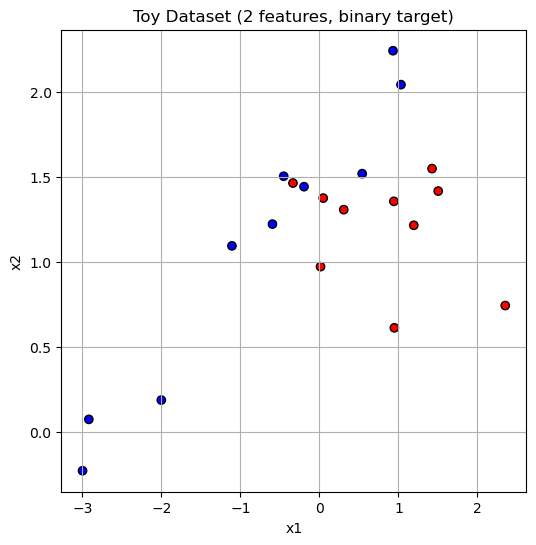

In [5]:
# Create synthetic 2D classification data
np.random.seed(42)

# 2 numerical features, binary classification
X, y = make_classification(n_samples=20, n_features=2, 
                           n_informative=2, n_redundant=0,
                           n_clusters_per_class=1)

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['target'] = y
print(df.head())
# Visualize data
plt.figure(figsize=(6, 6))
plt.scatter(df['x1'], df['x2'], c=df['target'], cmap='bwr', edgecolor='k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy Dataset (2 features, binary target)")
plt.grid(True)
plt.show()

## Key Functions Used in the Tree Model

Below are some of the core functions that I will use to build and apply my decision tree algorithm:

- **`gini_impurity(y)`**  
  - Calculates the Gini impurity of a list of class labels `y`.
  - Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the set.
  - Lower values indicate purer splits.

- **`find_best_split(df, features, target_col='target')`**  
  - Iterates over all provided features and possible split thresholds to find the best binary split based on Gini impurity.
  - Returns a dictionary with the best split's feature, threshold, impurity score, and the resulting left and right DataFrames after the split.

- **`plot_all_splits(df, split_history)`**  
  - Visualizes all decision splits made by the tree using Plotly.
  - Colors the data points by their class labels and overlays dashed lines to show the boundaries of each split.
  - Helpful for understanding how the tree is partitioning the feature space.

- **`predict_row(tree, row)`**  
  - Recursively traverses the decision tree for a single row of input data.
  - At each decision node, it checks the feature value and moves left or right accordingly until it reaches a leaf node.
  - Returns the predicted class label for that row.

- **`predict_tree(tree, df)`**  
  - Applies `predict_row` to every row in a DataFrame.
  - Returns a Series of predictions for all samples in the dataset.

These functions together enable both the construction of the tree model and the evaluation of its performance on data.


In [6]:
def gini_impurity(y):
    """Compute Gini impurity for a list of class labels."""
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)


In [7]:
def find_best_split(df, features, target_col='target'):
    best_gini = float('inf')
    best_split = None
    
    for feature in features:
        values = df[feature].sort_values().unique()
        midpoints = [(values[i] + values[i+1])/2 for i in range(len(values)-1)]
        
        for threshold in midpoints:
            left = df[df[feature] < threshold]
            right = df[df[feature] >= threshold]

            if len(left) == 0 or len(right) == 0:
                continue
            
            gini_left = gini_impurity(left[target_col])
            gini_right = gini_impurity(right[target_col])
            weighted_gini = (len(left) * gini_left + len(right) * gini_right) / len(df)

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_split = {
                    'feature': feature,
                    'threshold': threshold,
                    'gini': best_gini,
                    'left': left,
                    'right': right
                }
    
    return best_split


In [8]:


def plot_all_splits(df, split_history):
    df['target_str'] = df['target'].astype(str)

    # Start figure with all points
    fig = px.scatter(
        df,
        x='x1',
        y='x2',
        color='target_str',
        color_discrete_sequence=['blue', 'red'],
        title='All Tree Splits',
        opacity=0.7,
        labels={'x1': 'x1', 'x2': 'x2', 'target_str': 'Target'}
    )

    # For each split, add a restricted boundary line
    for split in split_history:
        feature = split['feature']
        threshold = split['threshold']
        subset_df = split['df']

        if feature == 'x1':
            fig.add_shape(
                type='line',
                x0=threshold, x1=threshold,
                y0=subset_df['x2'].min(), y1=subset_df['x2'].max(),
                line=dict(color='green', dash='dash')
            )
        else:  # 'x2'
            fig.add_shape(
                type='line',
                x0=subset_df['x1'].min(), x1=subset_df['x1'].max(),
                y0=threshold, y1=threshold,
                line=dict(color='purple', dash='dash')
            )

    fig.update_layout(
        showlegend=True,
        coloraxis_showscale=False,
        height=600,
        width=600
    )
    fig.show()


In [9]:
def predict_row(tree, row):
    if tree['leaf']:
        return tree['prediction']
    if row[tree['feature']] < tree['threshold']:
        return predict_row(tree['left'], row)
    else:
        return predict_row(tree['right'], row)

def predict_tree(tree, df):
    return df.apply(lambda row: predict_row(tree, row), axis=1)


## Designing a Custom Decision Tree with Feature Usage Limits

In this section, I define a recursive function `build_tree` to construct a decision tree from scratch using Gini impurity for splitting. This function is more flexible than typical implementations because it allows me to control not only the **maximum depth** and **minimum number of samples** per node but also **how many times each feature can be used for splitting**.

### Key Highlights of This Function:
- **Feature Usage Limitation**:  
  One of the most important customizations here is the ability to limit how many times each feature can be used in the tree using the parameter `max_feature_usage`.  
  This allows me to **prevent the model from over-relying on a single feature**, which can improve generalization and interpretability.

- **Split History Tracking**:  
  The function keeps track of all splits (including the feature used, threshold value, Gini score, and depth) in the `split_history` list. This information is useful for visualization and understanding the tree's structure.

- **Stopping Criteria**:  
  The recursion stops when one of the following conditions is met:
  - Maximum tree depth (`max_depth`) is reached
  - All samples belong to a single class
  - The number of samples falls below `min_samples`
  - No more features are available within their allowed usage limits

This design enables me to build interpretable and constrained decision trees tailored to specific modeling goals or data characteristics.


In [10]:
def build_tree(df, features, target_col='target', depth=0, max_depth=3, min_samples=5, 
               feature_usage=None, max_feature_usage=2, split_history=None):

    if feature_usage is None:
        feature_usage = {feature: 0 for feature in features}
    if split_history is None:
        split_history = []

    if (depth >= max_depth or 
        len(df[target_col].unique()) == 1 or 
        len(df) <= min_samples):
        return {
            'leaf': True,
            'prediction': df[target_col].mode()[0],
            'samples': len(df),
            'depth': depth
        }

    usable_features = [f for f in features if feature_usage[f] < max_feature_usage]
    if not usable_features:
        return {
            'leaf': True,
            'prediction': df[target_col].mode()[0],
            'samples': len(df),
            'depth': depth
        }

    split = find_best_split(df, usable_features, target_col)

    if not split:
        return {
            'leaf': True,
            'prediction': df[target_col].mode()[0],
            'samples': len(df),
            'depth': depth
        }

    # Track the split (no plotting)
    split_history.append({
        'depth': depth,
        'feature': split['feature'],
        'threshold': split['threshold'],
        'gini': split['gini'],
        'samples': len(df),
        'df': df.copy()  # Needed for plotting local boundaries
    })

    feature_usage[split['feature']] += 1

    # Recursive calls with copied feature usage
    left_subtree = build_tree(split['left'], features, target_col, 
                              depth + 1, max_depth, min_samples, 
                              feature_usage, max_feature_usage,
                              split_history)

    right_subtree = build_tree(split['right'], features, target_col, 
                               depth + 1, max_depth, min_samples, 
                               feature_usage, max_feature_usage,
                               split_history)

    return {
        'leaf': False,
        'feature': split['feature'],
        'threshold': split['threshold'],
        'gini': split['gini'],
        'depth': depth,
        'samples': len(df),
        'left': left_subtree,
        'right': right_subtree,
        'history': split_history
    }


## Applying the Custom Decision Tree with Limited Feature Usage

Now that I have defined the `build_tree` function, I apply it to the synthetic dataset using both features (`x1` and `x2`). I also rename the resulting tree to `tree_Testmodel_limited_features` for clarity.

### Model Settings:
- **Maximum Tree Depth**: 3  
- **Minimum Samples per Node**: 5  
- **Maximum Times a Feature Can Be Used**: 2  

These settings are chosen to keep the tree small and interpretable, and to ensure that no single feature dominates the decision-making process.

### Key Outputs:
- **Split History**:  
  I print each decision split made by the tree along with the depth, feature used, threshold value, Gini impurity, and number of samples at that point. This gives insight into how the model is learning from the data.

- **Visualizing the Splits**:  
  Using `plot_all_splits`, I visualize the decision boundaries created at each step of the tree-building process. This helps me understand how the model partitions the feature space.

- **Prediction and Evaluation**:  
  I use the trained tree to predict the target values for the dataset and compare them with the actual targets. The model's performance is summarized using:
  - **Accuracy**: Proportion of correctly predicted samples
  - **Misclassification Rate**: Proportion of incorrectly predicted samples

This final evaluation provides a quick check on how well the model is performing on the toy dataset.


Depth 0: Split on x1 < -0.39 (Gini = 0.286, Samples = 20)
Depth 1: Split on x2 < 1.43 (Gini = 0.190, Samples = 14)
Depth 2: Split on x1 < -0.26 (Gini = 0.267, Samples = 6)


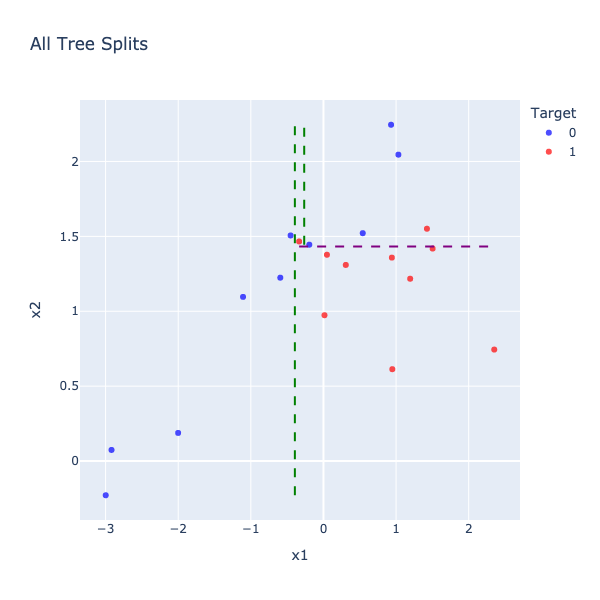

Accuracy: 0.95
Misclassification Rate: 0.05


In [11]:
tree_Testmodel_limited_features = build_tree(df, features=['x1', 'x2'], max_depth=3, min_samples=5, max_feature_usage=2)

# Print split history
for step in tree_Testmodel_limited_features['history']:
    print(f"Depth {step['depth']}: Split on {step['feature']} < {step['threshold']:.2f} (Gini = {step['gini']:.3f}, Samples = {step['samples']})")

plot_all_splits(df, tree_Testmodel_limited_features['history'])

# Make predictions
predictions = predict_tree(tree_Testmodel_limited_features, df)

# Compare to actual
actual = df['target']
correct = (predictions == actual)

accuracy = correct.mean()
misclassification_rate = 1 - accuracy

print(f"Accuracy: {accuracy:.2f}")
print(f"Misclassification Rate: {misclassification_rate:.2f}")


## Decision Tree Model without Feature Usage Limits

In this implementation, I build a decision tree without restricting how many times a feature can be used for splits. The key points of this approach are:

* **No limit on feature usage:** Unlike the previous model, any feature can be used repeatedly for splitting, regardless of how many times it has been used before.
* **Base cases:** The recursion stops when the tree reaches the maximum depth, the node is pure (only one class left), or the number of samples falls below a minimum threshold.
* **Best split selection:** At each step, the best split is found by evaluating all available features.
* **Split history tracking:** The split information is recorded for later visualization or analysis, but no plotting is done inside the tree-building function itself.
* **Recursive tree construction:** The tree is built recursively by splitting the data and calling the function on left and right subsets until base conditions are met.

This design allows the tree to freely select the best features for splits without constraints, potentially resulting in deeper or more complex trees depending on the data.


In [12]:
# Tree Builder Function (No Plotting Inside)
def build_tree_without_feature_limit(df, features, target_col='target', depth=0, max_depth=3, min_samples=5, split_history=None):
    if split_history is None:
        split_history = []

    # Base cases
    if (depth >= max_depth or 
        len(df[target_col].unique()) == 1 or 
        len(df) <= min_samples):
        return {
            'leaf': True,
            'prediction': df[target_col].mode()[0],
            'samples': len(df),
            'depth': depth
        }

    # Find best split using all features
    split = find_best_split(df, features, target_col)

    if not split:
        return {
            'leaf': True,
            'prediction': df[target_col].mode()[0],
            'samples': len(df),
            'depth': depth
        }

    # Save split info (no plotting here)
    split_history.append({
        'depth': depth,
        'feature': split['feature'],
        'threshold': split['threshold'],
        'gini': split['gini'],
        'samples': len(df),
        'df': df.copy()  # Needed for boundary-limited plotting
    })

    # Recursive tree building
    left_subtree = build_tree_without_feature_limit(
        split['left'], features, target_col, depth + 1, max_depth, min_samples, split_history
    )
    right_subtree = build_tree_without_feature_limit(
        split['right'], features, target_col, depth + 1, max_depth, min_samples, split_history
    )

    return {
        'leaf': False,
        'feature': split['feature'],
        'threshold': split['threshold'],
        'gini': split['gini'],
        'depth': depth,
        'samples': len(df),
        'left': left_subtree,
        'right': right_subtree,
        'history': split_history
    }


## Applying the Tree Model Without Feature Usage Limit

- **Build the tree** using the `build_tree_without_feature_limit` function with features `x1` and `x2`, a maximum depth of 3, and a minimum sample size of 5:
  ```python
  tree_Testmodel_Without_features_Limit = build_tree_without_feature_limit(df, features=['x1', 'x2'], max_depth=3, min_samples=5)


Depth 0: Split on x1 < -0.39 (Gini = 0.286, Samples = 20)
Depth 1: Split on x2 < 1.43 (Gini = 0.190, Samples = 14)
Depth 2: Split on x1 < -0.26 (Gini = 0.267, Samples = 6)


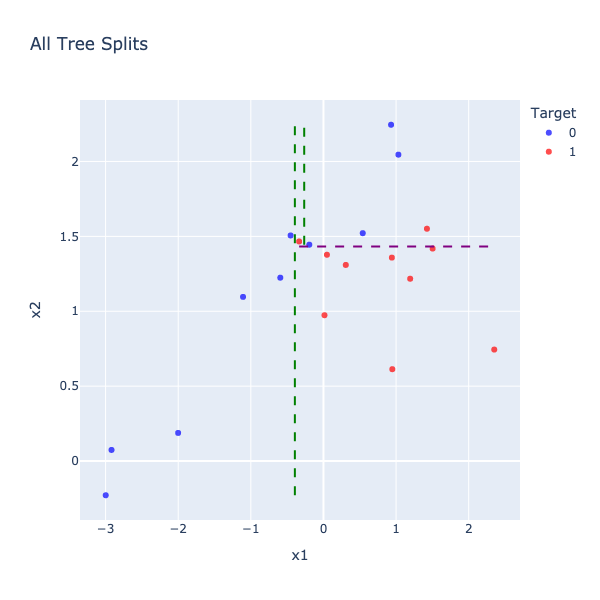

Accuracy of tree model 2: 0.95
Misclassification Rate of tree model 2 : 0.05


In [13]:
# Build tree
tree_Testmodel_Without_features_Limit = build_tree_without_feature_limit(df, features=['x1', 'x2'], max_depth=3, min_samples=5)

# Print splits
for step in tree_Testmodel_Without_features_Limit['history']:
    print(f"Depth {step['depth']}: Split on {step['feature']} < {step['threshold']:.2f} "
          f"(Gini = {step['gini']:.3f}, Samples = {step['samples']})")

# Plot all splits in one figure
plot_all_splits(df, tree_Testmodel_Without_features_Limit['history'])

# Make predictions
predictions = predict_tree(tree_Testmodel_Without_features_Limit, df)

# Compare to actual
actual = df['target']
correct = (predictions == actual)

accuracy = correct.mean()
misclassification_rate = 1 - accuracy

print(f"Accuracy of tree model 2: {accuracy:.2f}")
print(f"Misclassification Rate of tree model 2 : {misclassification_rate:.2f}")



### Comparing Tree Models With and Without Feature Usage Limits

**Results on the Randomly Generated Dataset:**
Depth 0: Split on x1 < -0.39 (Gini = 0.286, Samples = 20)
Depth 1: Split on x2 < 1.43 (Gini = 0.190, Samples = 14)
Depth 2: Split on x1 < -0.26 (Gini = 0.267, Samples = 6)

Accuracy of tree model 2: 0.95
Misclassification Rate of tree model 2 : 0.05

### Explanation:

- Both tree models — **one with a limit on how many times a feature can be used for splitting** (`max_feature_usage=2`), and **the other without any such limit** — produced **identical splits and performance** on this dataset.
  
- This indicates that **imposing a limit on feature usage did not affect the final tree structure or its accuracy** for this particular data.

- In practice, limiting feature usage can help **prevent overfitting** and promote model interpretability by forcing the tree to use a broader range of features, but on some datasets, the most informative splits naturally come from a limited number of features anyway.

- Since both methods gave the same result here, it means:
  - The dataset’s structure favors splits on the same features regardless of usage constraints.
  - Both approaches are **valid and correct** ways of building the decision tree model.
  - Applying feature usage limits **does not always change the model outcome**, but it is a useful tool to control complexity on other datasets.


**Summary:**  
Both approaches to building the decision tree — with and without limiting feature usage — are correct, and in this case, they lead to the same model and prediction accuracy. This confirms that the feature usage limit is a flexible option that can be enabled or disabled depending on the specific needs of your dataset and modeling goals.


---
# When Limiting Feature Usage in Tree Models Can Harm Accuracy

In the previous example, limiting the number of times a feature could be used in splits **did not affect** the tree structure or accuracy. However, this is not always the case.


## New Dataset: Vertical Stripes Classification

I generate a synthetic dataset with **vertical stripes of class labels** along the `x1` feature, with the following characteristics:

- The feature `x1` is divided into 8 equal-width stripes.
- Only stripes 2 and 6 belong to the positive class (`target = 1`).
- All other stripes belong to the negative class (`target = 0`).
- The `x2` feature varies randomly but does **not** directly influence the class.
- Both `x1` and `x2` are normalized between 0 and 1 for consistent scaling.


In [14]:
# Settings
np.random.seed(42)
n_stripes = 8  # one extra stripe to allow rightmost blue
samples_per_stripe = 50
data = []

# Generate main stripes
for stripe in range(n_stripes):
    x1_start = stripe
    x1_end = stripe + 1

    x1_vals = np.random.uniform(x1_start, x1_end, samples_per_stripe)
    x2_vals = np.random.uniform(0, 7, samples_per_stripe)

    # Target: red stripes (1) at stripes 2 and 6, rest are blue (0)
    if stripe in [2, 6]:
        target_vals = np.ones(samples_per_stripe)
    else:
        target_vals = np.zeros(samples_per_stripe)

    for x1, x2, t in zip(x1_vals, x2_vals, target_vals):
        data.append([x1, x2, int(t)])

# Create DataFrame
df_stripes = pd.DataFrame(data, columns=['x1', 'x2', 'target'])

# Normalize to 0-1 for consistency if needed by algorithm
df_stripes['x1'] = df_stripes['x1'] / df_stripes['x1'].max()
df_stripes['x2'] = df_stripes['x2'] / df_stripes['x2'].max()




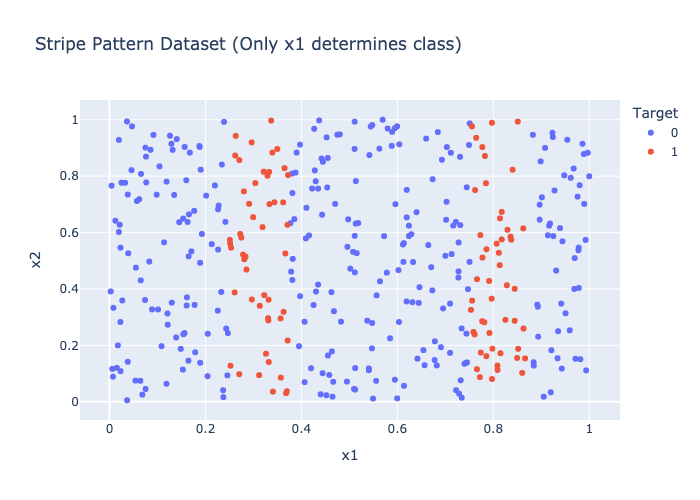

In [15]:

px.scatter(df_stripes, x='x1', y='x2', color=df_stripes['target'].astype(str),
           title='Stripe Pattern Dataset (Only x1 determines class)',
           labels={'color': 'Target'})



## Applying Decision Tree Model with Feature Usage Limit on the Stripes Dataset

In this example, we build a decision tree on the `df_stripes` dataset where:

- **Feature usage is limited**: each feature can be used at most 2 times (`max_feature_usage=2`).
- **Max tree depth** is set to 4 (`max_depth=4`), allowing the tree to grow deeper to capture complex patterns.
- **Minimum samples per node** is 5 (`min_samples=5`), which avoids splitting nodes with too few samples.
- The target column is explicitly set to `'target'`.


=== Split History ===
Depth 0: Split on x1 < 0.25 (Gini = 0.333, Samples = 400)
Depth 1: Split on x1 < 0.37 (Gini = 0.267, Samples = 300)
Depth 2: Split on x2 < 0.62 (Gini = 0.312, Samples = 250)
Depth 3: Split on x2 < 0.08 (Gini = 0.358, Samples = 156)


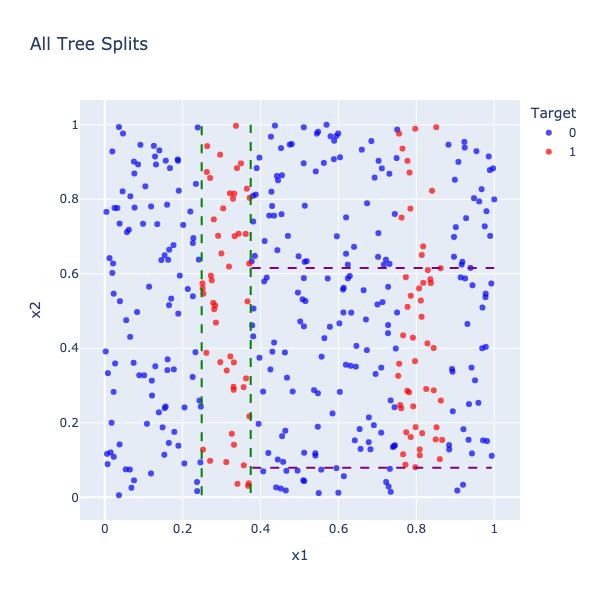

Accuracy of tree model with feature limit: 0.88
Misclassification Rate of tree model with feature limit: 0.12


In [16]:
# Make sure the target column is named 'target'
tree_model_with_feature_limit = build_tree(df_stripes, features=['x1', 'x2'], target_col='target',
                                           max_depth=4, min_samples=5, max_feature_usage=2)

# Print split history
print("=== Split History ===")
for step in tree_model_with_feature_limit['history']:
    print(f"Depth {step['depth']}: Split on {step['feature']} < {step['threshold']:.2f} "
          f"(Gini = {step['gini']:.3f}, Samples = {step['samples']})")

# Plot all splits with Plotly
plot_all_splits(df_stripes, tree_model_with_feature_limit['history'])

# Make predictions
predictions = predict_tree(tree_model_with_feature_limit, df_stripes)

# Compare to actual
actual = df_stripes['target']
correct = (predictions == actual)

accuracy = correct.mean()
misclassification_rate = 1 - accuracy

print(f"Accuracy of tree model with feature limit: {accuracy:.2f}")
print(f"Misclassification Rate of tree model with feature limit: {misclassification_rate:.2f}")



### Results of Tree Model with Feature Usage Limit

**Split History:**

- Depth 0: Split on **x1** < 0.25 (Gini = 0.333, Samples = 400)  
- Depth 1: Split on **x1** < 0.37 (Gini = 0.267, Samples = 300)  
- Depth 2: Split on **x2** < 0.62 (Gini = 0.312, Samples = 250)  
- Depth 3: Split on **x2** < 0.08 (Gini = 0.358, Samples = 156)  

**Accuracy and Misclassification:**

- **Accuracy:** 0.88  
- **Misclassification Rate:** 0.12  


### Insight

This result highlights a key point:

- This model applied a **limit on the number of times each feature can be used** (max_feature_usage=2). While the model successfully splits on features `x1` and `x2`, the **accuracy dropped to 88%**, which is lower than what we might expect with no feature usage limits.

**The issue arises because limiting how many times a feature can be used restricts the model's flexibility to make optimal splits**, especially in datasets like this "striped" data where certain features (like `x1`) carry crucial information repeatedly across different depth levels.

In the plotted split history and visualization, you might notice:

- The model **could not fully exploit the `x1` feature** to capture all the critical splits needed to separate the red stripes (target=1) accurately.
- As a result, the model relies more on `x2` splits that might be less informative, causing **increased impurity (higher Gini at deeper levels)** and reducing prediction accuracy.

The feature usage limit, while useful to prevent overfitting in some cases, **can harm model performance on complex datasets where repeated use of a key feature is necessary** to capture important decision boundaries.



## Tree Model Without Feature Usage Limit

This code builds and evaluates a decision tree model on the `df_stripes` dataset, **without restricting the number of times a feature can be used for splitting**.


**Key points of the code:**

- **Model Building:**  
  The function `build_tree_without_feature_limit()` is called with parameters:
  - `features=['x1', 'x2']` — the features used for splitting,
  - `target_col='target'` — the target variable,
  - `max_depth=4` — maximum depth of the tree,
  - `min_samples=5` — minimum number of samples required to split a node.
  
  Unlike the previous model, **there is no limit on how many times a single feature can be used** in the tree splits. This allows the model to repeatedly use the same feature if it helps improve purity.


=== Split History ===
Depth 0: Split on x1 < 0.25 (Gini = 0.333, Samples = 400)
Depth 1: Split on x1 < 0.37 (Gini = 0.267, Samples = 300)
Depth 2: Split on x1 < 0.75 (Gini = 0.200, Samples = 250)
Depth 3: Split on x1 < 0.87 (Gini = 0.000, Samples = 100)


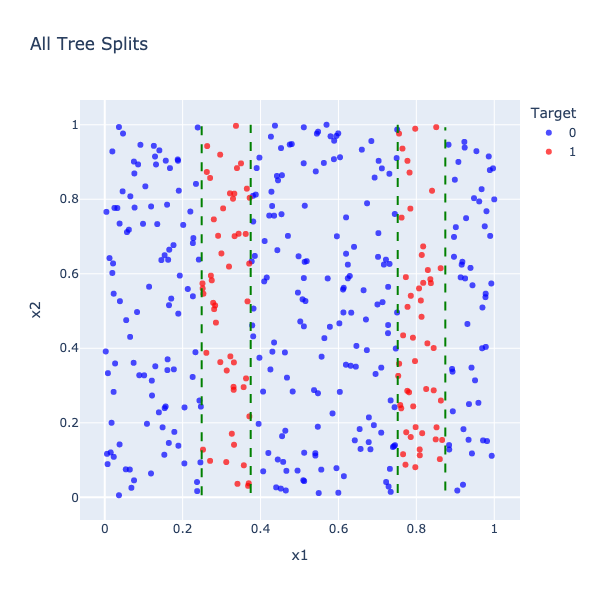

Accuracy of tree model without the limit on feature use: 1.00
Misclassification Rate of tree model without the limit on feature use: 0.00


In [17]:
# Make sure the target column is named 'target'
tree_model_Without_feature_limit = build_tree_without_feature_limit(df_stripes, features=['x1', 'x2'], target_col='target',
                  max_depth=4, min_samples=5)

# Print split history
print("=== Split History ===")
for step in tree_model_Without_feature_limit['history']:
    print(f"Depth {step['depth']}: Split on {step['feature']} < {step['threshold']:.2f} "
          f"(Gini = {step['gini']:.3f}, Samples = {step['samples']})")

# Plot all splits with Plotly
plot_all_splits(df_stripes, tree_model_Without_feature_limit['history'])


# Make predictions
predictions = predict_tree(tree_model_Without_feature_limit, df_stripes)  # use df_stripes here

# Compare to actual
actual = df_stripes['target']                  # use df_stripes here
correct = (predictions == actual)

accuracy = correct.mean()
misclassification_rate = 1 - accuracy

print(f"Accuracy of tree model without the limit on feature use: {accuracy:.2f}")
print(f"Misclassification Rate of tree model without the limit on feature use: {misclassification_rate:.2f}")



### Tree Model Without Feature Use Limit — Results

**Split History:**
- Depth 0: Split on x1 < 0.25 (Gini = 0.333, Samples = 400)
- Depth 1: Split on x1 < 0.37 (Gini = 0.267, Samples = 300)
- Depth 2: Split on x1 < 0.75 (Gini = 0.200, Samples = 250)
- Depth 3: Split on x1 < 0.87 (Gini = 0.000, Samples = 100)

**Performance Metrics:**
-  **Accuracy of tree model without the limit on feature use:** `1.00`
-  **Misclassification Rate:** `0.00`

### Insight

This result highlights a key point:

- When **no restriction is placed on how often a feature can be reused** (in this case, `x1` is reused at every depth), the model was able to **perfectly separate** the classes in this stripe-based dataset.
- This confirms that **feature repetition is essential** for accurately learning complex or structured data patterns (like alternating stripes), especially when only one feature holds the dominant predictive power.

In contrast, models with a restriction on feature reuse (like `max_feature_usage=2`) **fail to capture** such patterns effectively, leading to **lower accuracy**, as seen in previous results (accuracy = 0.88).

# Final Conclusion: Impact of Feature Usage Restriction in Decision Trees

This experiment demonstrates the **significant effect of limiting feature reuse** in decision tree construction. Both models were trained on the same dataset with the **same configuration parameters**:

- `max_depth = 4`
- `min_samples = 5`
- Dataset: `df_stripes` with features `['x1', 'x2']`
  
Yet, the performance outcomes were starkly different due to **only one difference**:
> The `max_feature_usage` parameter was set to `2` in one model and left unrestricted in the other.

## Key Takeaways

- **Unrestricted Feature Use**:
  - Allowed the model to **repeatedly split on the most informative feature (`x1`)** at multiple levels.
  - Resulted in **perfect classification** (Accuracy = 1.00, Misclassification Rate = 0.00).
  - Fully captured the **alternating stripe patterns** in the data.

- **Restricted Feature Use (max_feature_usage = 2)**:
  - Forced the model to split on the less-informative feature `x2` after two uses of `x1`.
  - Produced **weaker splits** at deeper levels.
  - Resulted in a **lower accuracy** of 0.88 and a **misclassification rate** of 0.12.
  - This shows that **premature feature switching** can hinder the model’s ability to learn data structures that are predominantly defined by one feature.

## Conclusion

- Even when using the **same model depth, dataset, and sample thresholds**, **restricting the number of times a feature can be used** can severely impact model performance.
- This approach sheds light on the **importance of feature selection freedom** in decision trees, especially for datasets where one feature holds **dominant predictive power**.
- Therefore, **feature usage restrictions should be applied with caution**, and only when justified by the problem domain or a need for model interpretability or generalization.

This experimental approach offers a **powerful lens** for understanding decision tree behavior and tuning tree-based models effectively.
